<a href="https://colab.research.google.com/github/HannaKi/Sentiment-analysis-with-IMDB-data/blob/main/Sentiment_analysis_with_IMDB_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix

from pprint import pprint
# from time import time
# import logging

## Load and inspect data

In [20]:
%%bash
wget -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
tar -xf aclImdb_v1.tar.gz

File ‘aclImdb_v1.tar.gz’ already there; not retrieving.



In [21]:
%%bash
cd aclImdb
cat README | head -1000

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a scor

In [22]:
%%bash
cd aclImdb/test/neg
for f in *txt; do echo $f>> /content/neg_file_names.txt; done # appends filenames to file

In [23]:
%%bash
cd aclImdb/test/pos
for f in *txt; do echo $f>> /content/pos_file_names.txt; done # appends filenames to file

In [24]:
def open_file_by_looping(path, file):
  f=open(file)
  filenames = f.readlines()
  reviews = []
  for filename in filenames:
    fname = path + filename
    fname =fname.rstrip()
    f = open(fname)
    review = f.readlines()
    # print(type(review))
    reviews.append(review) # or extend?
    f.close()
  f.close()
  flat_list = [item for sublist in reviews for item in sublist] # we have list of lists, it needs to be flattened
  return flat_list

neg_reviews = open_file_by_looping("aclImdb/test/neg/", "neg_file_names.txt")
print("Number of negative reviews:", len(neg_reviews))

pos_reviews = open_file_by_looping("aclImdb/test/pos/", "pos_file_names.txt")
print("Number of positive reviews:", len(pos_reviews))

reviews=neg_reviews+pos_reviews
len(reviews)

Number of negative reviews: 25000
Number of positive reviews: 25000


50000

Data quality affects the performance of all machine learning algorithms and neural networks. Poor data can not be improved even with a sophisticated algorithm. In this case our data is balanced (classes have equal 50 % share) and well behaving in many aspects.

This is seldom true in real life applications. In these cases data balance must be taken care of with for example stratification or giving different weigths to different classes. If data is grouped or datarecords are not independent, even more caution should be given to the training process since this might lead to test data "leaking" into training data and thus highly optimistic model performance measeures. 

For these reasons one should familiarize her with a new dataset before rushing into further steps of modeling. If it is discovered that the data is imbalanced, grouped etc. we can fix the issues uprising from the nature of the data before we feed it to the algorithm, or at least take it in account when analysing the results. 

In [26]:

reviews=neg_reviews+pos_reviews
len(reviews)

# make labels for the reviews:
labels = ['neg']*len(neg_reviews) + ['pos']*len(pos_reviews)
print(len(labels))

# make shuffled indices and shuffle both of labels and reviews with them
indices = list(range(len(labels)))
random.shuffle(indices)

labels = [labels[index] for index in indices]
reviews = [reviews[index] for index in indices]

for label, text in zip(labels[:5], reviews[:5]):
  print("label:", label, "\ntext:", text, "\n")

# for i in range(5):
#   print(labels[i])
#   pprint(reviews[i])

50000
label: neg 
text: It was so BORING! No plot whatsoever! Basically a watered-down version of the Lion King mixed in with Animal Farm. Again, no plot at all. Horrible! Worst hour and a half of my life!Oh my gosh! I had to walk out of the theatre for a few minutes just to get some relief! I maybe chuckled twice. All of the semi-funny parts are in the previews. I hate movies like that. Yeah, the movie pretty much sucked. I don't know how it got such good ratings and reviews. THERE IS NO PLOT OR STORYLINE!! If you do go see this movie, bring a pillow or a girlfriend/boyfriend to keep you occupied through out. Awful. I don't think I've ever gone to a movie and disliked it as much. It was a good thing that the tickets only cost five dollars because I would be mad if I'd have paid $7.50 to see this crap. 

label: neg 
text: Just do a little research on the making of this film. Something so simple as a Google search. It was funded by the US Army and promoted just in time for the elections

In [8]:
import re
pattern1=r"<br /><br />" 
reviews = [re.sub(pattern1, " ", item) for item in reviews]

for i in range(5):
  print(i)
  pprint(reviews[i])

0
('Masterpiece. Carrot Top blows the screen away. Never has one movie captured '
 'the essence of the human spirit quite like "Chairman of the Board." 10/10... '
 "don't miss this instant classic.")
1
('By-the-numbers, Oscar-hungry biopic about the late, great singer Ray '
 'Charles. There is one -- exactly one -- great scene in *Ray*. It occurs '
 "during a flashback to Charles' youth, after the boy become completely blind. "
 'Running into the sharecropper house which he shares with his mother, he '
 'trips over a chair and sprawls on the floor. He cries out for his mother; '
 'she, in keeping with her philosophy that a person should "stand on their own '
 'two feet", observes silently and pensively from the kitchen, waiting to see '
 'if the boy can fall back on his own resources. The boy proves to be up to '
 'the challenge, using his ears and memory to locate a kettle on a stove, a '
 'nearby fire-pit, the grass blowing in the wind outside of a window, the '
 'scuttling of a cric

In [9]:
# s = r"\s\tWord"
# prog = re.compile(s)
# prog

# re.sub(some_regex, some_replacement.replace('\\', '\\\\'), input_string)

In [10]:
# import re
# pattern1=r"<br /><br />" # something fishy is going on with HTML tags. Get rid of them
# s = "\\'"
# print(s)
# # pattern2=re.escape(r"\'")
# # print("p2:", pattern2)
# pattern3 = s
# print(pattern3)
# # print(pattern3.replace('\\', '\\\\'))
# print(chr(39))

# fixed = re.sub(pattern3, chr(39), reviews[8])
# fixed_n = re.sub(pattern1, " ", fixed)
# fixed_n

## UDPipe segmenting (is this needed?)

Let's try to tokenize and sentence split the IMDB data with UDPipe machine learned segmenter!
Documentation: https://ufal.mff.cuni.cz/udpipe/users-manual


In [11]:
!wget -nc https://github.com/TurkuNLP/intro-to-nlp/raw/master/Data/en.segmenter.udpipe

!pip3 install ufal.udpipe

import ufal.udpipe as udpipe

model = udpipe.Model.load("en.segmenter.udpipe")
pipeline = udpipe.Pipeline(model,"tokenize","none","none","horizontal") # horizontal: returns one sentence per line, with words separated by a single space


--2021-04-01 15:14:47--  https://github.com/TurkuNLP/intro-to-nlp/raw/master/Data/en.segmenter.udpipe
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TurkuNLP/intro-to-nlp/master/Data/en.segmenter.udpipe [following]
--2021-04-01 15:14:47--  https://raw.githubusercontent.com/TurkuNLP/intro-to-nlp/master/Data/en.segmenter.udpipe
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17394186 (17M) [application/octet-stream]
Saving to: ‘en.segmenter.udpipe’

en.segmenter.udpipe 100%[===================>]  16.59M  37.5MB/s    in 0.4s    

2021-04-01 15:14:48 (37.5 MB/s) - ‘en.segmenter.udpipe’ saved [17394

In [12]:
segmented_document = pipeline.process(reviews[8])
print(segmented_document)

Well every scene so perfectly presented .
Never before had I seen such a movie that has meaning in almost every scene .
Well while I was watching this movie I remembered watching " Amilie " .
Amilie is also a similar kind of movie with more fun and fantasy touch .
These movies are both based on a same plot line .
But both of them are Perfectly perfect in there own way and being able to create a world of their own .
Red is able to provoke lots of thoughts in people about destiny and dejavu s .
And I am still thinking about it .
The story is great and the ending is a bit funny .
I was laughing in the end scene .
Well funny how this three movie Red White and Blue are connected .
All in all a great work of art .
A work of a masterman .
10/10



Preprocessing exhausts resources so let's cut down the input and take 100 st words from each review

In [13]:
cut = [item[:1000] for item in reviews]

# for i in range(10):
#   print(len(cut[i]))
#   print(cut[i])

In [14]:
segmented  = [pipeline.process(text) for text in cut]

KeyboardInterrupt: ignored

In [ ]:
for i in range(30):
  print(segmented[i])

## train dev test split

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.33)

print(X_train[:5])
print(y_train[:5])
print(len(X_train), len(y_train))

['"Red Sonja" is flawed, weak and lacking. Even the camp-ness isn\'t good.<br /><br />There are only two good things about "Red Sonja"; The costumes (even though the Red Sonja costume is ridiculous. It\'s ironic that a girl who is even afraid to be touched by men, because she was raped, still choose to wear so few little clothes, even when it rains.) and the music by Ennio Morricone. Still the movie is somewhat watchable but certainly not recommendable.<br /><br />The story is extremely simple and they didn\'t even bother to make it interesting. The story could have been forgotten if there had been some good action sequences and some humor, both are present but are seriously flawed in many ways. The movie takes itself too serious and tries to impress but fails completely.<br /><br />Brigitte Nielsen is an horrible leading lady. I don\'t know who\'s accent is worse; Hers or Arnie\'s and on top of that; She can\'t act. There is also absolutely no chemistry between the two characters whic

## Tfidf

Since we are dealing with text data we need to transform it to format a basic SVM can handle. For that purpose I use sklearn TfidfVectorizer. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=50000)
fm_train = vectorizer.fit_transform(X_train)
fm_test = vectorizer.transform(X_test)

In [ ]:
# input column number is limited by the vectorizer

print(f"We have {fm_train.shape[0]} rows and {fm_train.shape[1]} columns in the training data")
print(f"And {fm_test.shape[0]} rows and {fm_test.shape[1]} columns in the training data")


In [ ]:
# type of the input data is scipy.sparse.csr.csr_matrix
print(type(fm_train))

# What does it mean? It looks like this:
print(fm_train[0:2:])

# each row contains tfidf weights for a single review. 
# Columns are mostly empty because most words in the vovabulary do not appear in every sentence
# This is why sparse format is used
print(fm_train[0:2].todense())

In [ ]:
for (idx, item) in enumerate(vectorizer.vocabulary_.items()):
  print("Key:", item[0], "\tValue:",item[1])
  if (idx==8):
    break

## Finding the best model with GridSearch Cross Validation

The model can be trained by exploring the hyperparameters one by one or with nested for-loops. It will how ever become a frustrating task to keep up with the hyperparameter combinations and obtained performence values. A more systematic way to do this is by using GridSearch (GS). 

GridSearchCV allows us set grid (or multiple vectors) of hypermarameters to try with. The idea is to try and find a sweet spot (best performance measure) by adjusting the grid. K-fold CV also introduces a new hyperparameter, which affects the training results, namely the number of folds.

GS uses K-fold Cross Validation (CV) to find the best performing model. Depending on the algorithm and chosen parameters the data is "folded" (divided into subsets) n times and each of these folds is used once for testing while n-1 folds are used for training. Cross validation is also useful when the data set size is limited and we would like to "eat the cake and keep it".

For the task I have chosen Linear Support Vector Classifier. When classifying multiple classes and the number of classes in *n* LinearSVC implements “one-vs-the-rest” multi-class strategy, thus training *n* models ([Scikit-learn](https://scikit-learn.org/stable/modules/svm.html#svm-classification)). At prediction time all the classifers "vote", and item will be assigned to class with the lowest cost. Other possible models for text classification problem are for example K-Nearest-Neighbors and Multinomial Naive Bayes. Also classifiers can be compared with GS.

A simple pipeline is built for both the preprocessor (vectorizer) and the classifier so that we are able to find the best hyperparameters for both of them at once.

Sources:

[GridSearchCV documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

[GridSearchCV example 1](https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html) 

[GridSearchCV example 2](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html) 

[SVM documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

[GridSearchCV scoring parameters](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) 

#### TfidfVectorizer with SVM

In [28]:
costs = np.logspace(-1, 1, num=5, endpoint = False)

pipeline = Pipeline([
    ('vec', TfidfVectorizer()),
    ('clf', LinearSVC()),
])

parameters = {
    #'vec__binary': (True, False), # Previous runs revealed this does not seem to matter
    'vec__max_features': (10000, 30000),
    'vec__ngram_range': ((1, 1), (1, 2), (1, 3)),  
    'clf__C': (costs), 
}

# find the best parameters for both the feature extraction and the classifier
print("Running grid search...")
gridsearch = GridSearchCV(pipeline, parameters, cv=3, verbose=1, n_jobs=-1) # n_jobs=-1: use as many cores as possible
gridsearch.fit(X_train, y_train)
print()

print(f"Best score: {gridsearch.best_score_:0.2}")

print("Best of the observed hyperparameters:")
best_parameters = gridsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
      print(f"{param_name}: {best_parameters[param_name]}")

Running grid search...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 26.7min finished



Best score: 0.94
Best of the observed hyperparameters:
clf__C: 0.6309573444801934
vec__max_features: 30000
vec__ngram_range: (1, 2)


So was the selected model clearly the best?

In [29]:
# set column visibility in pandas df
pd.set_option("max_colwidth", None)

# extract mean score for each parameter combination trained
means = gridsearch.cv_results_['mean_test_score'] 

GSCV_results = pd.DataFrame(list(zip(means, gridsearch.cv_results_['params'])), 
               columns =['Score', 'Parameters']) 
# sort by the score
GSCV_results.sort_values(by="Score", ascending=False, inplace=True)
print(GSCV_results.head(7))

       Score                                                                              Parameters
16  0.944176  {'clf__C': 0.6309573444801934, 'vec__max_features': 30000, 'vec__ngram_range': (1, 2)}
22  0.943431   {'clf__C': 1.584893192461114, 'vec__max_features': 30000, 'vec__ngram_range': (1, 2)}
23  0.943282   {'clf__C': 1.584893192461114, 'vec__max_features': 30000, 'vec__ngram_range': (1, 3)}
17  0.942952  {'clf__C': 0.6309573444801934, 'vec__max_features': 30000, 'vec__ngram_range': (1, 3)}
28  0.941820   {'clf__C': 3.981071705534973, 'vec__max_features': 30000, 'vec__ngram_range': (1, 2)}
29  0.940685   {'clf__C': 3.981071705534973, 'vec__max_features': 30000, 'vec__ngram_range': (1, 3)}
21  0.939578   {'clf__C': 1.584893192461114, 'vec__max_features': 30000, 'vec__ngram_range': (1, 1)}


Not! This seemd to be a tight race.

##### Performance evaluation

Test accuracy: 0.96



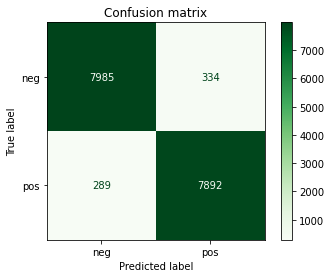

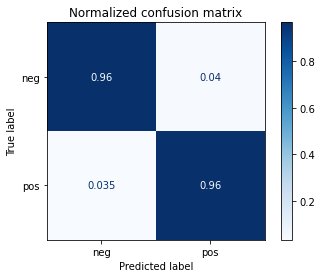

In [31]:
# classifier=grid_search.best_estimator_
# classifier.fit(feature_matrix_train, train_label)

predictions = gridsearch.predict(X_test)
acc = accuracy_score(y_test, predictions)
# conf = confusion_matrix(test_labels, predictions)

print(f"Test accuracy: {acc:0.2f}")
print()
# note here we have to feed in the test data not feature matrix since esitimator is a pipeline, not a classifier!
plot_confusion_matrix(gridsearch.best_estimator_, X_test, y_test, cmap='Greens', values_format='d')  
plt.title("Confusion matrix")
plt.show()

plot_confusion_matrix(gridsearch.best_estimator_, X_test, y_test, cmap='Blues', normalize='true')  
plt.title("Normalized confusion matrix")
plt.show()

In [32]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         neg       0.97      0.96      0.96      8319
         pos       0.96      0.96      0.96      8181

    accuracy                           0.96     16500
   macro avg       0.96      0.96      0.96     16500
weighted avg       0.96      0.96      0.96     16500



Test accuracy of 96 percent is high. The model handled both of the classes well. This can be seen from the confusion matrix and from the classification report where precision and recall are in balance for both os the labels.

#### NN


To build a NN we need to

1.   turn numpy vectors to tensors
2.   know the shape of input layer (number of features)
3.   know the shape of output layer (number of classes)

TfidfVectorizer gives the 2nd one and LabelEncoder (for example) the 3rd one. (or just len(set(train_labels))

"Keras models can be used in scikit-learn by wrapping them with the KerasClassifier or KerasRegressor class."(https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)

In [ ]:
# 1) np vectors to TF tensors
import tensorflow as tf
import numpy as np

def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

Since vectorizer affects the shape of the NN, we do not optimize it as a part of the pipeline.

In [ ]:
# 2) size of input 
new_token_pattern=r"(?u)\b\w\w+\b|!+|\?+"
vectorizer = TfidfVectorizer(token_pattern=new_token_pattern, max_features=10000)

ft_matrix = vectorizer.fit_transform(train_texts)
ft_matrix.shape # so we need the second dimension for building the nn
input_size = ft_matrix.shape[1]
input_size

9132

In [ ]:
# 3) size_of_output_layer
# use encoded labels when fitting the model and for testing
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder() #Turns class labels into integers
class_numbers_train = label_encoder.fit_transform(train_labels)

# print("class_numbers shape=", class_numbers_train.shape)
print("class labels", label_encoder.classes_) #this will let us translate back from indices to labels

output_size = len(label_encoder.classes_)
print("Shape of output layer:", output_size)

class labels ['anger' 'joy' 'not-anger' 'not-joy']
Shape of output layer: 4


In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout
from keras import optimizers

def build_sequential_nn(input_size=100, output_size=2, hiddenlayer_size=200, drop_out= 0.3, learning_rate=0.001): # let's make 200 default
  model = Sequential()
  model.add(Input(shape = (input_size, )))
  model.add(Dense(hiddenlayer_size, activation = "tanh", ))
  model.add(Dropout(rate=drop_out)) # Dropout regularizer to avoid over fitting
  model.add(Dense(output_size, activation = "softmax"))
  model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=['accuracy'])
  # loss="categorical_crossentropy" for multiclass classification
  return model

model = build_sequential_nn(input_size=input_size, output_size=output_size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1826600   
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 804       
Total params: 1,827,404
Trainable params: 1,827,404
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import FunctionTransformer
from keras.callbacks import EarlyStopping
import time

pipeline = Pipeline([
    ('trans', FunctionTransformer(convert_sparse_matrix_to_sparse_tensor)), # wrapper for custom function
    ('clf', KerasClassifier(build_fn=build_sequential_nn)), # wrapper for Keras model
])

parameters = {
    'clf__hiddenlayer_size': (200, 250), 
    'clf__input_size': ([input_size]), # GS sets ALL the params
    'clf__output_size': ([output_size]),
    'clf__batch_size': (16, 32),
    'clf__drop_out': (0.2, 0.3, 0.4),
    'clf__epochs': (3, 5), # do not use early stopping callback, number of epochs is best treated as a hyper parameter: https://stackoverflow.com/questions/48127550/early-stopping-with-keras-and-sklearn-gridsearchcv-cross-validation
    'clf__learning_rate': (0.001, 0.01)
}

t0=time.time()
print("Running grid search...")
gridsearch = GridSearchCV(pipeline, parameters, verbose=1, n_jobs=1) # n_jobs=-1: use as many cores as possible OR use GPU
gridsearch.fit(ft_matrix, class_numbers_train)
print()

print(f"Best score: {gridsearch.best_score_:0.2}")

print("Best of the observed hyperparameters:")
best_parameters = gridsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
      print(f"{param_name}: {best_parameters[param_name]}")

t1=time.time()

Running grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Streaming output truncated to the last 5000 lines.
Epoch 8/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0904 - accuracy: 0.9580
Epoch 9/15
117/117 [==============================] - 1s 11ms/step - loss: 0.0914 - accuracy: 0.9516
Epoch 10/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0859 - accuracy: 0.9463
Epoch 11/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0820 - accuracy: 0.9519
Epoch 12/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0696 - accuracy: 0.9622
Epoch 13/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0730 - accuracy: 0.9588
Epoch 14/15
117/117 [==============================] - 1s 10ms/step - loss: 0.0676 - accuracy: 0.9579
Epoch 15/15
30/30 [==============================] - 0s 1ms/step - loss: 1.7463 - accuracy: 0.4635
Epoch 1/15
117/117 [==============================] - 2s 10ms/step - loss: 1.3173 - accuracy: 0.3978
Epoch 2/15
117/117 [=================

In [ ]:
print(f"Time elapsed{t1-t0}")

In [ ]:
means = gridsearch.cv_results_['mean_test_score'] 

GSCV_results = pd.DataFrame(list(zip(means, gridsearch.cv_results_['params'])), 
               columns =['Score', 'Parameters']) 
# sort by the score
GSCV_results.sort_values(by="Score", ascending=False, inplace=True)
print(GSCV_results.head(7))

       Score                                                                                                                                                                  Parameters
26  0.478328  {'clf__batch_size': 32, 'clf__drop_out': 0.2, 'clf__epochs': 3, 'clf__hiddenlayer_size': 250, 'clf__input_size': 9132, 'clf__learning_rate': 0.001, 'clf__output_size': 4}
40  0.476172  {'clf__batch_size': 32, 'clf__drop_out': 0.4, 'clf__epochs': 3, 'clf__hiddenlayer_size': 200, 'clf__input_size': 9132, 'clf__learning_rate': 0.001, 'clf__output_size': 4}
32  0.473606  {'clf__batch_size': 32, 'clf__drop_out': 0.3, 'clf__epochs': 3, 'clf__hiddenlayer_size': 200, 'clf__input_size': 9132, 'clf__learning_rate': 0.001, 'clf__output_size': 4}
34  0.472739  {'clf__batch_size': 32, 'clf__drop_out': 0.3, 'clf__epochs': 3, 'clf__hiddenlayer_size': 250, 'clf__input_size': 9132, 'clf__learning_rate': 0.001, 'clf__output_size': 4}
0   0.472321  {'clf__batch_size': 16, 'clf__drop_out': 0.2, 'clf__epochs': 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test accuracy: 0.50



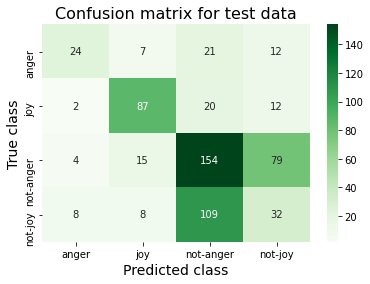

In [ ]:
import seaborn as sns

# prepare test data
ftm_test=vectorizer.transform(test_texts) # model needs to be Sequential for predicting
class_numbers_test = label_encoder.transform(test_labels)

# predict
raw_predictions = gridsearch.predict(ftm_test)
predictions=label_encoder.inverse_transform(raw_predictions)

# results
acc = accuracy_score(test_labels, predictions)
print(f"Test accuracy: {acc:0.2f}")
print()
cf_mat = tf.math.confusion_matrix(
    class_numbers_test, raw_predictions, num_classes=None, weights=None
)

def plot_cf_matrix(mat):
  sns.heatmap(mat, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Greens')
  plt.title("Confusion matrix for test data", fontsize = 16)
  plt.ylabel("True class", fontsize = 14)
  plt.xlabel("Predicted class", fontsize = 14)

plot_cf_matrix(cf_mat)

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

       anger       0.63      0.38      0.47        64
         joy       0.74      0.72      0.73       121
   not-anger       0.51      0.61      0.55       252
     not-joy       0.24      0.20      0.22       157

    accuracy                           0.50       594
   macro avg       0.53      0.48      0.49       594
weighted avg       0.50      0.50      0.49       594



In [ ]:
# From NLP deep learning and ADA courses:

#  Additionally accuracy on the permutated test sets are computed for the purpose of 
# ensuring that performance with actual data differs from performance with junk data.

 # accuracy on permutated test set
    # permutated = np.random.permutation(df_test.reg)
    # perm_accuracy, _ = mnb_compute(vocab['test_fm'], permutated, mnb)

#### Sidenote: How to tackle randomness?

What should be done to make sure our results are not random: resuffle the data, run the CV again. Do this x 10 and take the average.

Run with permuted data

For joy and not-anger the model finds a bit less than 70 percent of the relevant samples (recall). For joy also precision (relevance of the selected ones) is rather high, close to 80 percent, so the model detects joy the best. This can be seen also from the f1-score. 

Not-anger, the biggest class in our data, has the second highest f1-score and recall close to 70 percent, but since significant amount of not-joy is assigned under not-anger label, the precision for the class is less than 50 percent. Anger seems to be difficult to detect (recall less than 30 percent) but when the model does so, precision is colse to 60 percent. As already mentioned, not-joy is frequently classified to be not-anger, and that is why all the performance measures for this class are poor.

We reach test accuracy around 50 percent. This slightly outperforms our rather naive baseline of guessing the most common class but does not give us results to celebrate with.

Initially we had one data set for "joy" and "not-joy" and other for "anger" and "not-anger". Test accuracy was around 0.84 while testing with anger and joy data separately.

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

       anger       0.59      0.27      0.37        64
         joy       0.76      0.68      0.72       121
   not-anger       0.49      0.67      0.56       252
     not-joy       0.21      0.14      0.17       157

    accuracy                           0.49       594
   macro avg       0.51      0.44      0.45       594
weighted avg       0.48      0.49      0.47       594



In [ ]:
# set the hyperparameter grid
costs = np.logspace(-4, 2, num=6, endpoint = False) # array with values: 0.00001, 0.0001, 0.001, 0.01 0.1, 1

Reminder:

Precision: TP/TP+FP --> fraction of true positives of all the items predicted positive. i.e. relevance among the selected items

Recall: TP/TP+FN --> fraction of true positives of all the truly positives. i.e relevant items

- Optimize precision: To achieve high precision we can set high threshold for predicting positive. But this would lead to discarding many positives and thus high FN and bad recall

- Optimize recall: To achieve high recall we must minimize FP. This is achieved by setting a low thrwshold for predicting positive. But this again leads to bad precision!

- Goal: Seek for balance. This migt be achieved by setting the metrics used in training.

## Model performance evaluation


Let's take a look at the classified test documents. Can we get an insight what went wrong and why?

In [ ]:
df = pd.DataFrame({'true': y_test,
                   'prediction':list(predictions),
                   'document': X_test})
print(df.shape)
df.head()

In [ ]:
df1 = df[(df['true']=='neg') & (df['prediction']=='pos')]
print(df1.shape)
df1.head(20)

In [ ]:
df2 = df[(df['true']=='pos') & (df['prediction']=='neg')]
print(df2.shape)
df2.head(20)

## Final notes